## 3D Printed Tube Transition Piece Example
- A "Turtle Graphics" approach is used to define the extrusion paths:  A series of `(segment length, change of heading angle)` - tuples defines a path segment. e.g. the tuple `(2*pi ,2*pi)` defines a unit circle, the tuple `(1,0)` a straight line of unit length, and `(0,-30*deg)` turns on the spot `30deg` to the right.
- Print layers are defined as a list of path offsets and extrusion widths:  Each layer has a different `(offset,extrusion width)`-list defined. The result is a "Brickwork" of overlapping extrusions.
- Complex numbers are used for the 2D coordinates:  2D translations and rotations are simple additions and multiplications of complex numbers. E.g. the complex expression `(3+5j)*1j**(30/90)` rotates the point `(x=3,y=5)` counter-clockwise by `30deg` around the origin.

In [ ]:
import fullcontrol as fc
from math import tau
from copy import deepcopy

In [ ]:
# printer/gcode parameters

design_name = 'transition piece'
nozzle_temp = 220
bed_temp = 120
print_speed = 1000
fan_percent = 0
printer_name='generic' # generic / ultimaker2plus / prusa_i3 / ender_3 / cr_10 / bambulab_x1 / toolchanger_T0

In [ ]:
# design parameters

bottom_width= 20
# width at the top (mm)
# default value: 20

bottom_depth = 30
# depth at the top (mm)
# default value: 30

bottom_radius = 3
# fillet radius at the top (mm)
# default value: 3

height = 30
# Height of the adapter (excluding flanges)
# default value: 30

top_width= 26
# width at the top (mm)
# default value: 26

top_depth = 26
# depth at the top (mm)
# default value: 26

top_radius = 13
# fillet radius at the top (mm)
# default value: 13

detail_tolerance = 0.03
# allowable deviation of the extrusion path from the ideal path (mm)
# smaller values result in finer details at the cost of more points and larger files
# default value: 0.03

bottom_EW = 1.0
# Extrusion Width at the bottom of the single-wall section (mm) - Width of printed lines - recommended value: >= 1.4x nozzle diameter
# default value: 1.0

top_EW = 1.0
# Extrusion Width at the top of the single-wall section (mm) - Width of printed lines - recommended value: >= 1.4x nozzle diameter
# default value: 1.0

EH = 0.2
# Extrusion Height (mm) - Height of printed lines (i.e. layer thickness) - recommended value: <=0.4x EW
# default value: 0.2

BottomFlange=1
# bottom flange design [0..2] 0=None
# default value:1

TopFlange=1
# top flange design [0..1] 0=None
# default value:1


In [ ]:
# definition functions for the conversion of the turtle path circle segments to extrusion path points
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi,exp,sign
deg=pi/180 #conversion from degrees to radians

def mirrorTurtlePath(turtlePath):
    "This function returns the original path with its mirror image appended to it."
    return turtlePath + turtlePath[-1::-1]

def polygonArea(p):
  "This function calculates the area of an arbitrary polygon.\n"
  "The 2D points have to be passed as an numpy array of complex values (e.g. (x=5,y=3) -> 5+3j )"
  def crossprod(v1,v2):
    return v1.real*v2.imag-v2.real*v1.imag
  return 0.5*np.sum(crossprod(p[range(-1,len(p)-1)],p))

def turtlePathArea(turtlePath):
  "This function calculates the area on the left side of a turtle path. \n"
  "The path has to be defined as a list of arc segments: [(length, heading angle change in radians),..] \n"
  "The path needs to be closed (start point = ent point) for meaningful results."
  nSegs=len(turtlePath)
  dl,dang=np.array(turtlePath).transpose()
  ang=np.cumsum(dang)
  ang=exp(1j*np.insert( ang,0,0))
  dang_2=np.exp(1j*dang/2)
  viSeg=np.sinc(dang/(2*pi))*dl*dang_2*ang[:-1]
  pSeg=np.cumsum(viSeg)
  olderr=np.geterr()
  np.seterr(divide='ignore',invalid='ignore')#suppress the warnings from 0/0 = nan. nansum assumes nan=0, which is the correct value in this case
  area=polygonArea(pSeg) +  np.nansum((dl/dang)**2*(dang/2.0-dang_2.real*dang_2.imag))
  np.seterr(**olderr)
  return area

def turtlePathLength(turtlePath):
  "This function calculates the total length of a turtle path."
  return sum(l for l,ang in turtlePath)

def turtlePath2ComplexPoints(turtlePath,p0=0+0j,a0=1+0j,scale=1.0,tol=0.05,offs=0,loops=1,return_startpoint=False,return_heading=False):
  "This function returns a sequence of points on a turtle path. \n"
  "A turtlePath is a list of (arc length, heading change in radians) tuples. \n"
  "The function returns points on the path as complex numbers, where x=real, and y=imag. \n"
  "Optionally, the headings at each point can also be returned as unit vectors. \n"
  'The parameter "tol" defines the resolution. It is the maximum allowable \n'
  "difference between the arc and the secant connecting two consecutive\n"
  "path points on the arc. Smaller values for tol will result in \n"
  "more points per arc segment."
  a=a0
  p=p0
  p-=1j*a*offs
  if return_startpoint:
      yield p,a if return_heading else p
  for _ in range(loops):
      for l,da in turtlePath:
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for _ in range(n):
          p+=v
          if return_heading:
            yield p,a
          else:
            yield p
          v*=dda
          a*=dda

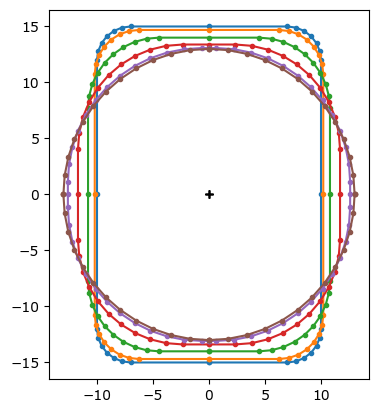

In [ ]:
#definition of a cross-section of the transition piece as a series of circle segments (turtle path)
from math import cos,pi

def transitionPiece(width,depth,radius):
    'This function returns a turtle path for a rectangle with a width of "width", a depth of "depth", \n'
    'and rounded corners with a radius of "radius".'
    'If the radius is too large, an exception is raised.'
    if (radius>(width/2)) or (radius>(depth/2)) or (radius<0):
        raise Exception(f'argument "radius" out of bounds: transitionPiece({width=}, {depth=}, {radius=})')
    #first, one quadrant is defined ...
    quadrant=[(width/2-radius, 0.0),(radius*90*deg,90*deg),(depth/2-radius,0.0)]
    #... which is then mirrored and duplicated to give the full shape:
    return mirrorTurtlePath(quadrant)*2 #this is a list multiplication: concatenate the same list twice

bottom_area=turtlePathArea(transitionPiece(bottom_width,bottom_depth,bottom_radius))
top_area=turtlePathArea(transitionPiece(top_width,top_depth,top_radius))

n=6

start_heading=1+0j# to the right
for i in range(n):
  alpha=(1+cos(i/(n-1)*pi))/2 #alpha for smooth blending
  blend_radius=                                  bottom_radius * alpha  +                top_radius * (1-alpha)
  blend_width =2*blend_radius + (bottom_width-2*bottom_radius) * alpha  +  (top_width-2*top_radius) * (1-alpha)
  blend_depth =2*blend_radius + (bottom_depth-2*bottom_radius) * alpha  +  (top_depth-2*top_radius) * (1-alpha)
  desired_blend_area  =                      (bottom_area**0.5 * alpha  +             top_area**0.5 * (1-alpha))**2
  blend_turtlePath=transitionPiece(blend_width,blend_depth,blend_radius)
  actual_blend_area=turtlePathArea(blend_turtlePath)
  scale=(desired_blend_area/actual_blend_area)**0.5
  path_start=0-1j*blend_depth*scale/2
  px,headings=np.array(list(turtlePath2ComplexPoints(blend_turtlePath,scale=scale,p0=path_start,a0=start_heading,tol=detail_tolerance,offs=0,return_startpoint=True,return_heading=True))).transpose()
  plt.plot(0,0,'k+')
  plt.plot(px.real,px.imag,'.-')
plt.gca().set_aspect('equal')
plt.show()

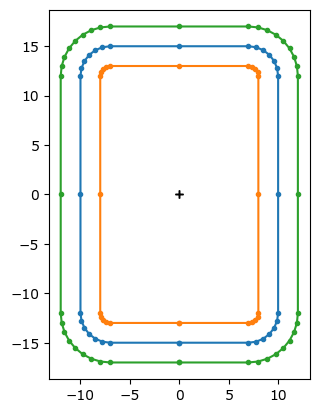

In [ ]:
#Path offset example.
#This is used to produce the flanges, in combination with the "Brickwork" defined below:

n=4
from math import cos,pi
sh=1+0j
for offs in (0,-2,2):
  turtlePath=transitionPiece(bottom_width,bottom_depth,bottom_radius)
  scale=1
  sp=0-1j*bottom_depth*scale/2
  px,headings=np.array(list(turtlePath2ComplexPoints(turtlePath,scale=scale,p0=sp,a0=sh,tol= 0.03,offs=offs,return_startpoint=True,return_heading=True))).transpose()
  plt.plot(0,0,'k+')
  plt.plot(px.real,px.imag,'.-')
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
#Definitionof the "Brickwork" that defines the offsets and extrusion width
#of the cross-section that makes up the bottom and (upside-down) the top flange.
def fitBricks(minx,maxx,n):
  "This function returns a list of n (offset, width) tuples \n"
  "that evenly fill the space between xmin, and xmax. \n"
  w=maxx-minx
  dx=float(w)/n
  x=minx+dx/2
  result=[(x,abs(dx))]
  for i in range(n-1):
    x+=dx
    result.append((x,abs(dx)))
  if n>3:
    result=[result[1]]+[result[0]]+result[n-2:]+result[2:n-2]
  return result
#definition of "Brickwork" for a flange.
#For the flange to be flush with the wall of the tube, the tube wall has to be offset by
#1/2 its width so that the defined path is flush with the inside of the tube wall.
#The "Brickwork" is designed to be printed upside down as well, so it can be used in reverse
#for the top edge. The wall thickness of the tube itself shuold be about 1mm.
flangeBrickwork1=[fitBricks(2.0,0.2,2)]+\
       [fitBricks(w2,0,n) for w2,n in ((4.4/2,3),(4.6/2,4))]+\
       [((cw/2,cw),(w2-ww/2,ww)) for w2,ww,cw in[ \
        (4.8/2,1.0,1.0),\
        (5.0/2,1.0,0.8),\
        (5.0/2,0.9,0.6)]+\
        [(5.0/2,0.9,0.5)]*2+[\
        (4.8/2,0.9,0.5),\
        (4.6/2,0.9,0.5),\
        (4.4/2,1.0,0.5),\
        (2.0,1.0,0.7)]\
        ]+\
        [fitBricks(1.8,0,2),\
         fitBricks(1.6,0,3),\
        fitBricks(1.4,0,2),\
        fitBricks(1.2,0,2)]+\
       [[((1.1-0.6*i/50.0)/2.0,1.1-0.6*i/50.0)] for i in range(1)]

#flange design #2 may not print well upside-down:
flangeBrickwork2= [fitBricks(-w2,w2,n) for w2,n in ((3.6/2,4),(4.0/2,5),(4.4/2,6),(4.6/2,5))]+ \
      [((0.0,cw),(-w2+ww/2,ww),(w2-ww/2,ww)) for w2,ww,cw in[ \
        (4.8/2,1.0,1.0),\
        (5.0/2,1.0,0.8),\
        (5.0/2,0.9,0.6)]+\
        [(5.0/2,0.9,0.5)]*2+[\
        (4.8/2,0.9,0.5),\
        (4.6/2,0.9,0.5),\
        (4.4/2,1.0,0.5)]+\
        [(w2,1.0,0.5)for w2 in(4.0/2,3.6/2,3.2/2,2.8/2)]+\
        [(2.4/2,0.9,0.6)]
        ]+\
      [fitBricks(-w2,w2,n) for w2,n in ((2.0/2,2),(1.6/2,3),(1.2/2,2))]
#shift offsets for brickwork2 by 0.5mm
flangeBrickwork2=[[(offs+0.5,w) for offs,w in layer] for layer in flangeBrickwork2]

flangeBrickworks=[None,flangeBrickwork1,flangeBrickwork2]

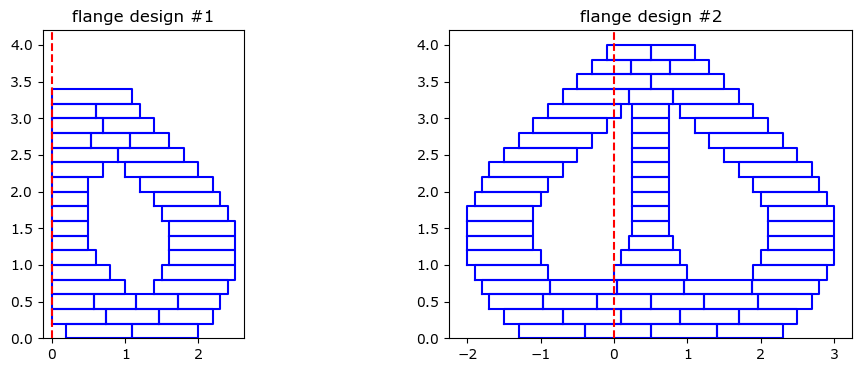

In [ ]:
#Showing the "Brickwork".
#Each rectangle represents one extrusion path.
hl=0.2
fig,axs=plt.subplots(1,2,figsize=(12,4))
for k in [1,2]:
  ax=axs[k-1]
  ax.set_aspect('equal')
  ax.set_title(f'flange design #{k}')
  ax.set_ylim(0,4.2)
  ax.plot((0,0),(0,10),'r--',zorder=5)
  for i,layer in enumerate(flangeBrickworks[k]):
    y=i*hl
    if y>5.5:
      break
    for x,w in layer:
      axs[k-1].plot((x-w/2,x+w/2,x+w/2,x-w/2,x-w/2),(y,y,y+hl,y+hl,y),'b-',zorder=1)


In [ ]:
#The complete "FullControl" version of everything shown above:
from math import cos,pi

steps=[]
nwipe=5
nskip=5
nskirt=2
skirtoffs=3.0


#print the bottom flange
turtlePath=transitionPiece(bottom_width,bottom_depth,bottom_radius)
start_point=0-1j*bottom_depth/2
start_heading=1+0j
scale=1.0
z=0 #start at the surface of the build plate
jt=0#point counter
if BottomFlange!=0:
  for i,layer in enumerate(flangeBrickworks[BottomFlange]):
    z+=EH
    if i==0: # at the first layer, add extrusion paths outside of the object to get the flow started
      layer=[(skirtoffs-(0.6*(i-nskirt)),0.7) for i in range(nskirt)]+layer
    for offs,ew in layer:
      path=list(turtlePath2ComplexPoints(turtlePath,p0=start_point,a0=start_heading,tol=detail_tolerance,scale=scale,offs=offs))
      n=len(path)#the changing offset may change the number of points
      steps.append(fc.Extruder(on=False))
      steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=hl,width=ew))
      jt=jt%n
      p=path[jt]
      steps.extend(fc.travel_to(fc.Point(x=p.real,y=p.imag,z=z)))
      for _ in range(nskip): #skip a few points along the path before switching the extruder on
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
      steps.append(fc.Extruder(on=True))
      for _ in range(n):#extrude a full path (n points)
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
      steps.append(fc.Extruder(on=False))
      for _ in range(nwipe):#continue on the path for a few points to "iron" over the start of the extrusion
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))

#print the transition piece in spiral mode
zb=z          #use the top of the flange as the bottom of the transition section
zt=zb+height  #height from the desigh parameters
old_eh=-1
old_ew=-1
steps.append(fc.Extruder(on=False))
eh_min=EH*0.25 #start the first spiral with a non-zero eztrusion height
path=list(turtlePath2ComplexPoints(turtlePath,p0=start_point,a0=start_heading,tol=detail_tolerance,scale=scale,offs=offs))
n=len(path)
while  z<(zt+hl):
  #re-calculate the path once for each layer
  alpha=(1+cos((z-zb)/(zt-zb)*pi))/2
  blend_radius=                                  bottom_radius * alpha  +                top_radius * (1-alpha)
  blend_width =2*blend_radius + (bottom_width-2*bottom_radius) * alpha  +  (top_width-2*top_radius) * (1-alpha)
  blend_depth =2*blend_radius + (bottom_depth-2*bottom_radius) * alpha  +  (top_depth-2*top_radius) * (1-alpha)
  blend_EW =                                         bottom_EW * alpha  +                    top_EW * (1-alpha)
  desired_blend_area  =                      (bottom_area**0.5 * alpha  +             top_area**0.5 * (1-alpha))**2
  blend_turtlePath=transitionPiece(blend_width,blend_depth,blend_radius)
  actual_blend_area=turtlePathArea(blend_turtlePath)
  scale=(desired_blend_area/actual_blend_area)**0.5
  path_start=0-1j*blend_depth*scale/2
  dzdj=EH/n #z changes by EH for n points, one complete spiral
  n_new=0 # we do not know exactly how many points are in the path ahead of time, so let's count as we go
  for p in turtlePath2ComplexPoints(blend_turtlePath,scale=scale,p0=path_start,a0=start_heading,tol= detail_tolerance,offs=ew/2):
      n_new+=1
      z+=dzdj#this should add up to about EH for one complete path
      if ((zt-(z-hl))/hl)<1e-2: #too small extrusion heights can cause gcodes with scientific number formats, e.g. 1e-6
          break                 #I think this is a bug in FullControl.
      eh=max(0,min(z-zb+eh_min if (z-zb)<(eh_min+EH) else EH,zt-(z-EH),zt-zb))#smaller extrusion heights at top and bottom
      if (abs(eh-old_eh)/EH)>0.01 or abs(ew-old_ew)>0.005:#only update the extrusion geometry if there has been a significant change
        steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=eh,width=blend_EW))
        old_eh=eh
        old_ew=blend_EW
      steps.append(fc.Point(x=p.real,y=p.imag,z=min(z,zt)))
      steps.append(fc.Extruder(on=True))#switch extruder on after moving to the first point
  n=n_new #n changes slightly as the path is recalculated

#print the top flange
if TopFlange!=0:
  turtlePath=transitionPiece(top_width,top_depth,top_radius)
  scale=1.0
  path_start=0-1j*top_depth/2*scale
  start_heading=1+0j
  z=zt#reset z to the top of the spiral

  for i,layer in enumerate(reversed(flangeBrickworks[TopFlange])):
    z+=hl
    for offs,ew in layer:
      path=list(turtlePath2ComplexPoints(turtlePath,p0=path_start,a0=start_heading,tol=detail_tolerance,scale=scale,offs=offs))
      n=len(path)
      steps.append(fc.Extruder(on=False))
      steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=EH,width=ew))
      jt=jt%n
      p=path[jt]
      steps.extend(fc.travel_to(fc.Point(x=p.real,y=p.imag,z=z)))
      for _ in range(nskip):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
      steps.append(fc.Extruder(on=True))
      for _ in range(n):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
      steps.append(fc.Extruder(on=False))
      for _ in range(nwipe):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))

steps.append(fc.Extruder(on=False))
steps.extend(fc.travel_to(fc.Point(x=0,y=0)))
# offset the whole procedure. z dictates the gap between the nozzle and the bed for the first layer, assuming the model was designed with a first layer z-position of 0
model_offset = fc.Vector(x=100.0, y=100.0, z=0.0*hl)
steps = fc.move(steps, model_offset)

In [ ]:
fc.transform(steps, 'plot', fc.PlotControls(style='tube',color_type='print_sequence',raw_data=False, initialization_data={'extrusion_width': bottom_EW, 'extrusion_height': EH}));

In [ ]:
gcode_controls = fc.GcodeControls(
    printer_name=printer_name,
    save_as=design_name,
    initialization_data={
        'primer': 'no_primer',
        'print_speed': print_speed,
        'nozzle_temp': nozzle_temp,
        'bed_temp': bed_temp,
        'fan_speed':fan_percent,
         })
gcode = fc.transform(steps, 'gcode', gcode_controls)